In [ ]:
#the point of this notebook is to work with the data  located in enid->flight_classification-> data to first generate some labels for
#unlabeled data contained in mocked_with_unused_labels.csv. This data file is abstract geometric shapes that represent some notion of a 
#flight path. You can see these shapes by running the first cell below.

#the second cell is really where the work is done. The data is loaded, labeled and used to train a CNN.
#this abstract data is then labeled in the prototypes.py file and those generated labels are compared to the labels that are in the data file,
#This is just a way I was looking at this to try to determine if my prototype comparison was working. We  can see in the the visualization
#that the prototype matching works well for commercial, not as well for training and surviellance, however we need to keep in mind that the
#data is abstract and the prototypes are much more realistic. I think that once we use some real data instead of this abstract data,
# we can expect better results of the prototype matching. This prototype matching is an unsupervised step.

#the labeled data is then used to train a model and then that model is tested with categorized_test_data.csv. This data is also abstract,
# but less so than the training data. We can see that the CNN is doing well with the abstract commercial data, but same issue with training
# and surviellance data. This is likely due to the same issue as above, the abstract data is not as realistic as the prototypes.

#I think the next steps here is to begin trying this mechanism with more realistic data and then we can make adjustments.


#The interesting concept here is in the prototype comparison. First of all the prototypes are generated functionally and are not deterministic.
#right now. This was a simple way for me to kind of generate some prototypes that represented my idea of what these categories of flight look like
#we can generate these manually, or Matt can find a good data set to use as prototypes based on his knowledge. It really doesn't matter how
# we define them what matters is that each prototype is defined as a list of lat/long, alt, and speed. 

# the comparison uses dynamic time warping to compare features in the data. For exammple:
#Dynamic Time Warping (DTW) to compare time series data. In your flight classification context, this could mean:

#1D DTW (dtw_ndim=1): If you're comparing only one feature per time step (e.g., altitude or velocity).
#2D DTW (dtw_ndim=2): If you're comparing two features simultaneously (e.g., latitude & longitude).
#Higher dimensions (dtw_ndim > 2): If you're using multiple flight attributes (e.g., lat, lon, altitude, velocity, heading).

#DTW (Dynamic Time Warping) is an algorithm used to measure the similarity between two time series that may vary in speed or length. 
# It finds the optimal 
# alignment between two sequences by warping the time axis to minimize difference

#in this algorithm, the paths are normalized and weighting is applied to try to better include the effects of speed and altitude
#to better separate training and surveillance flights. 

#there are other prototypes defined that are not being used right now, but could be used in the future. For example emergency flights,
#but these are probably similar to training flights, but with maybe a takeoff and landing being in different places. 


#An important note is that this requires python 3.12 because the tensorflow version doesn't support 3.13 yet.


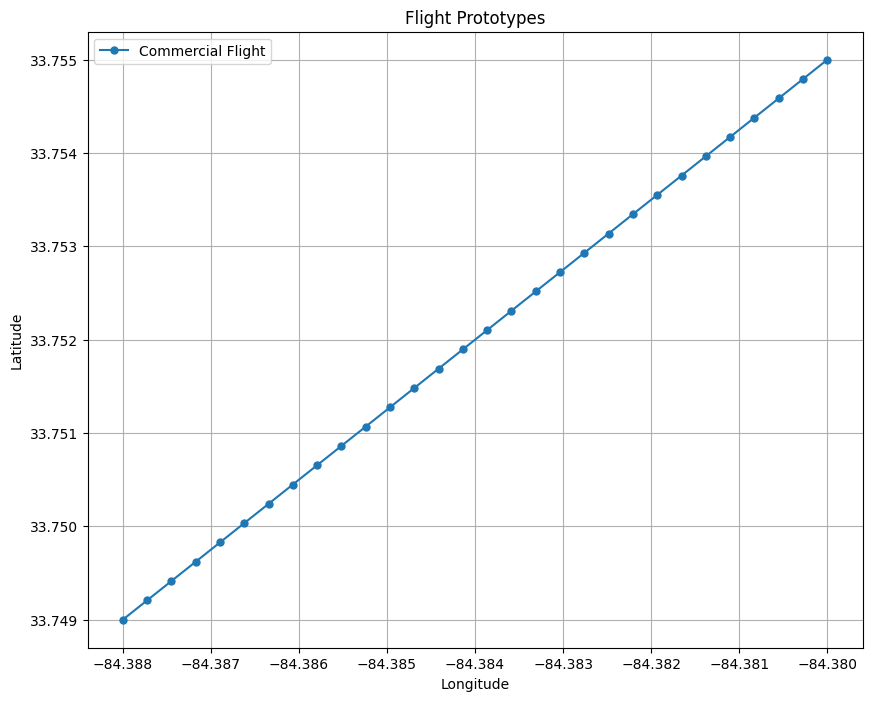

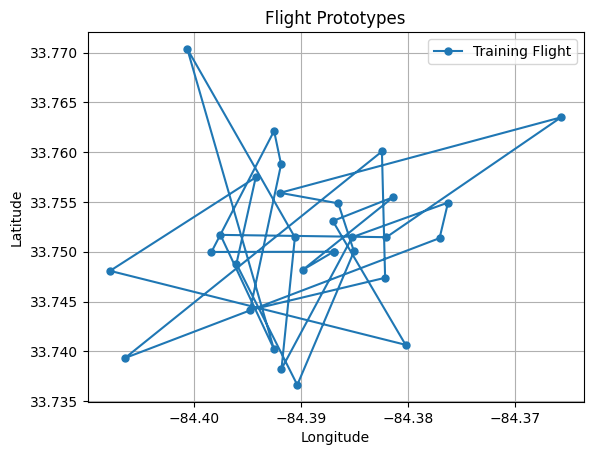

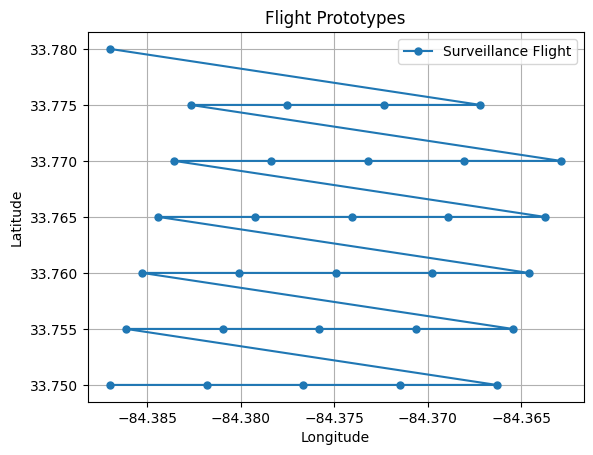

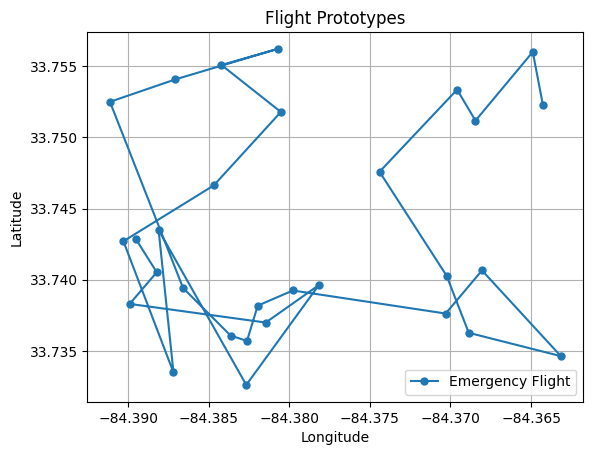

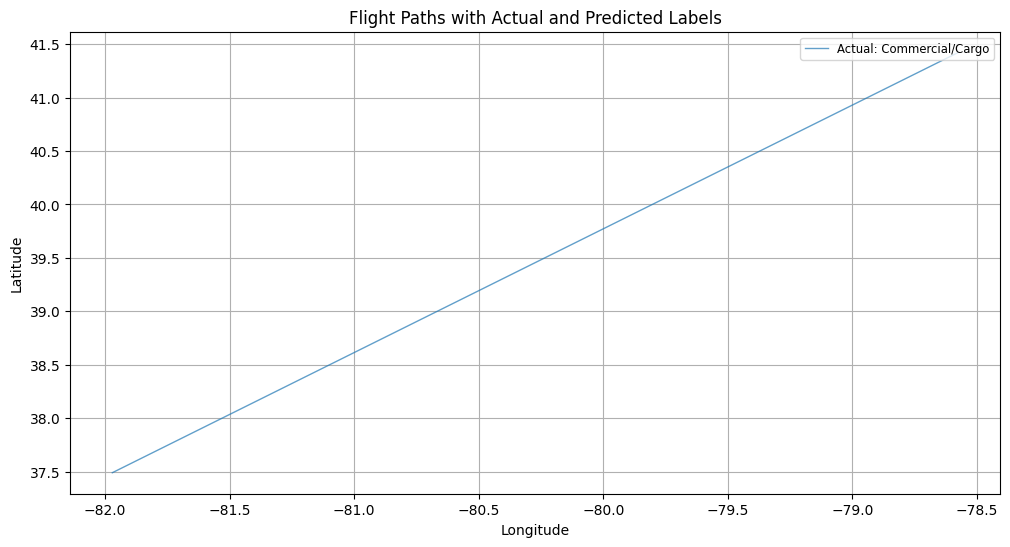

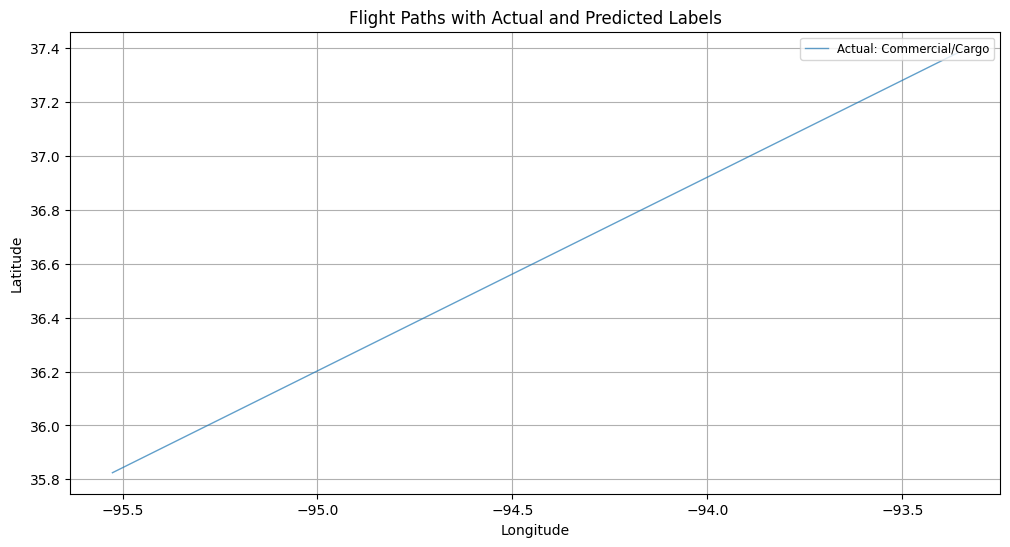

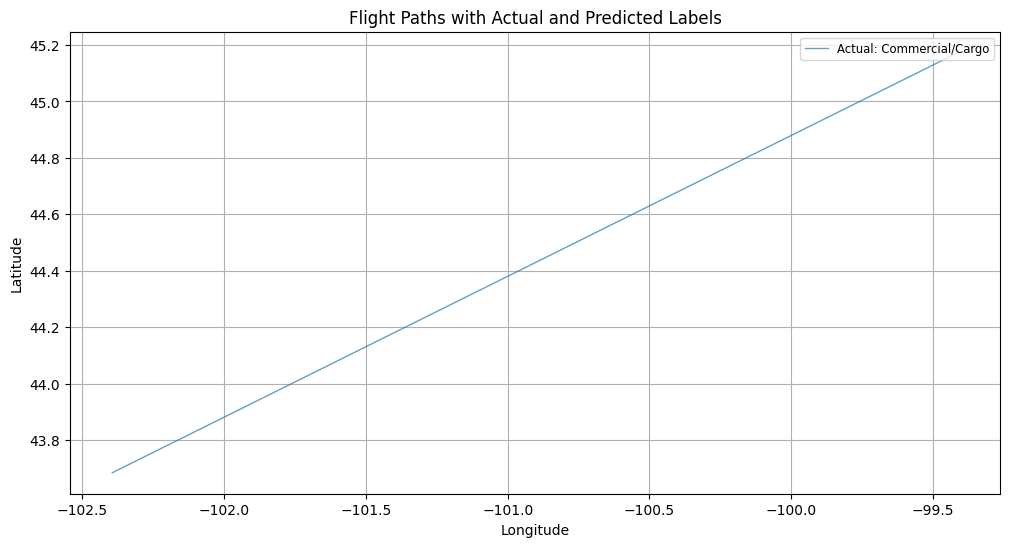

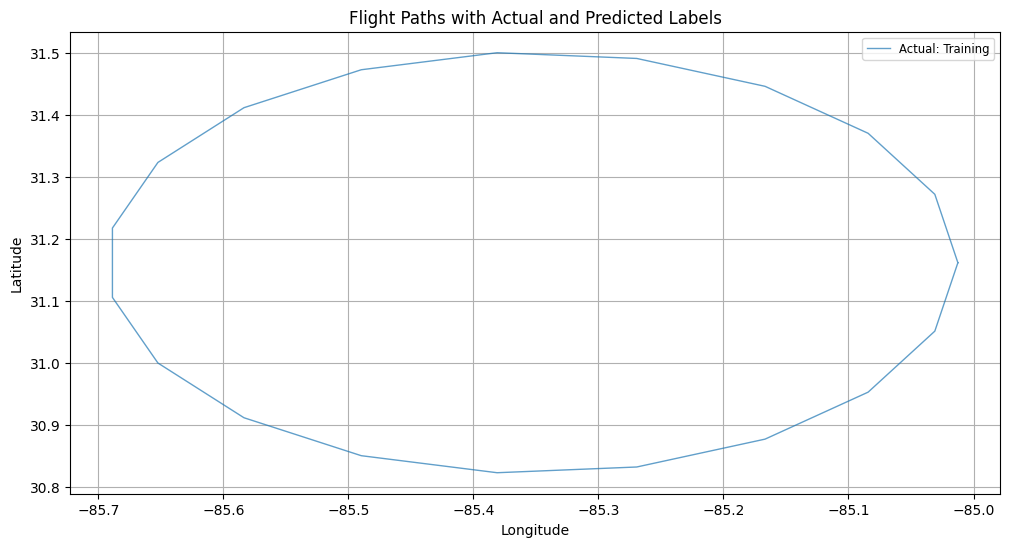

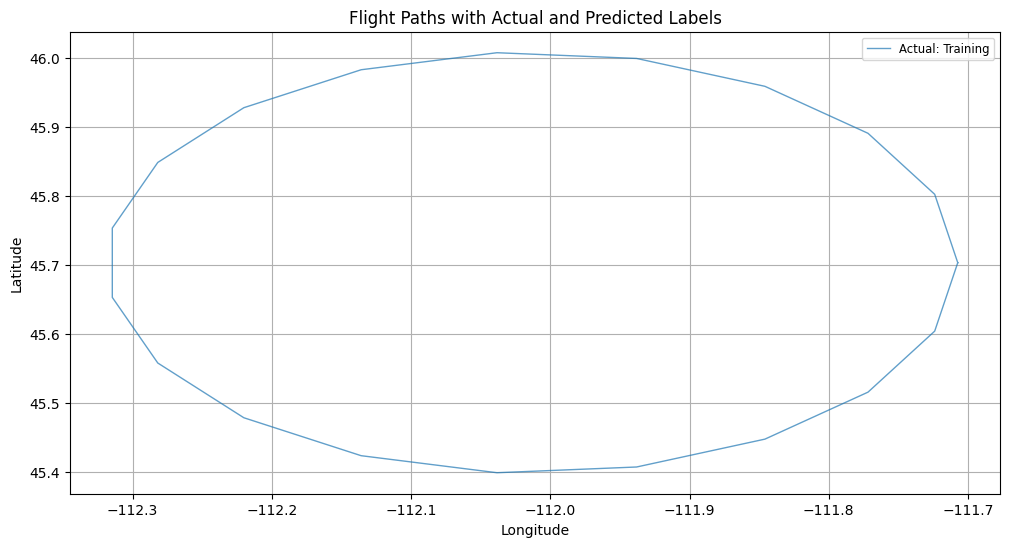

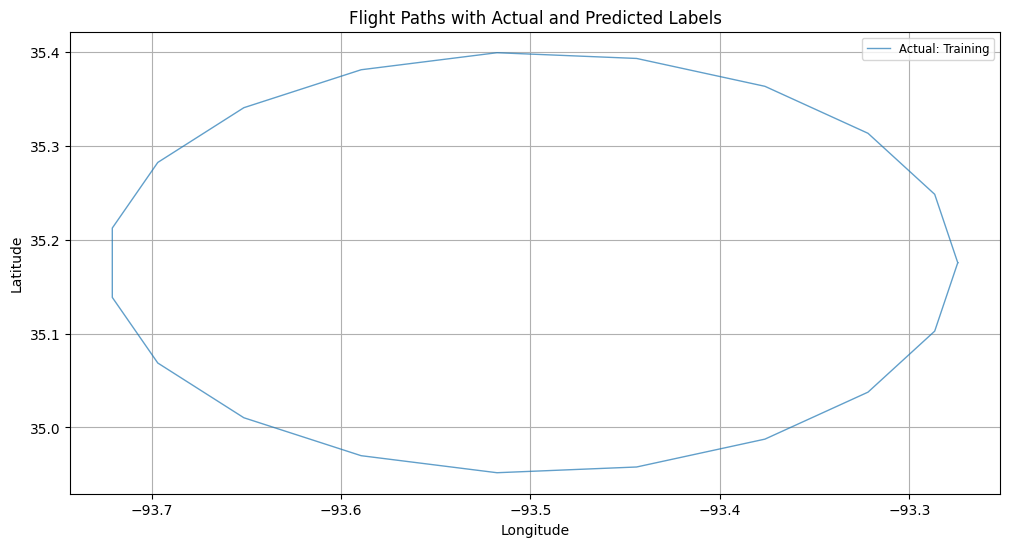

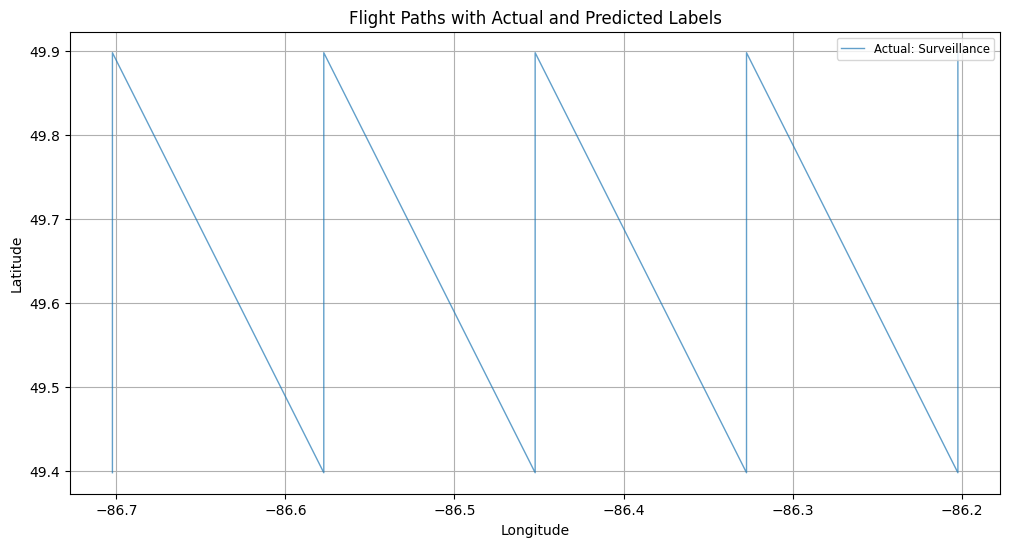

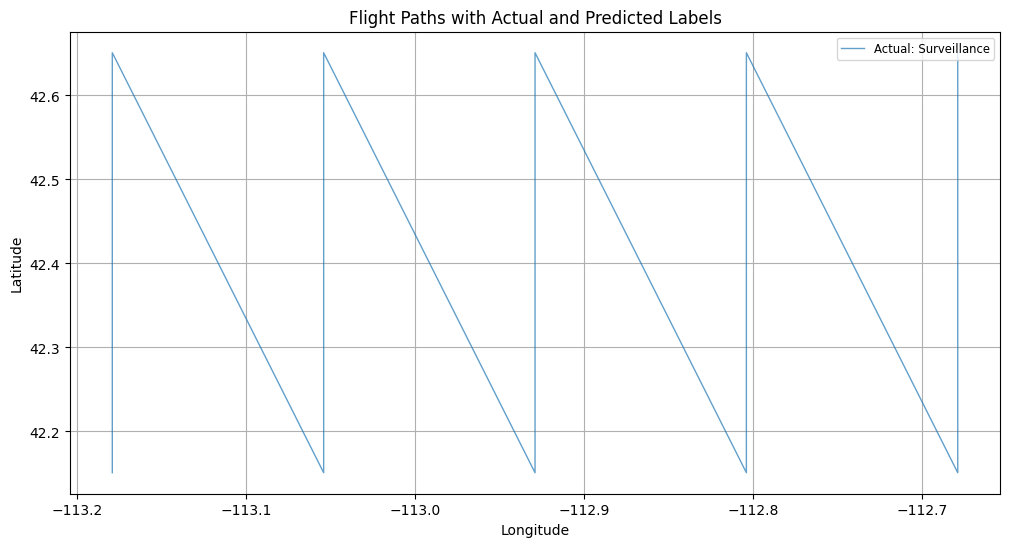

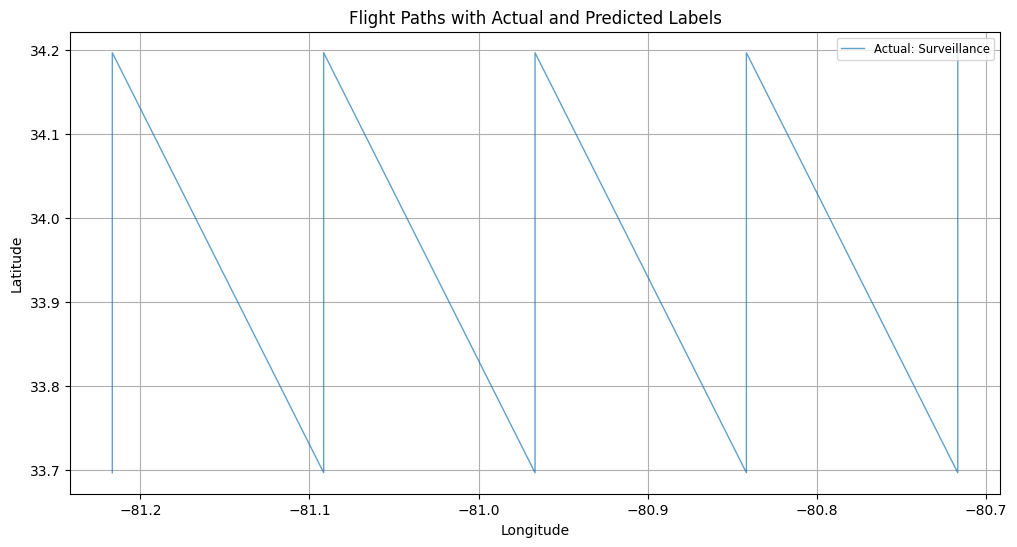

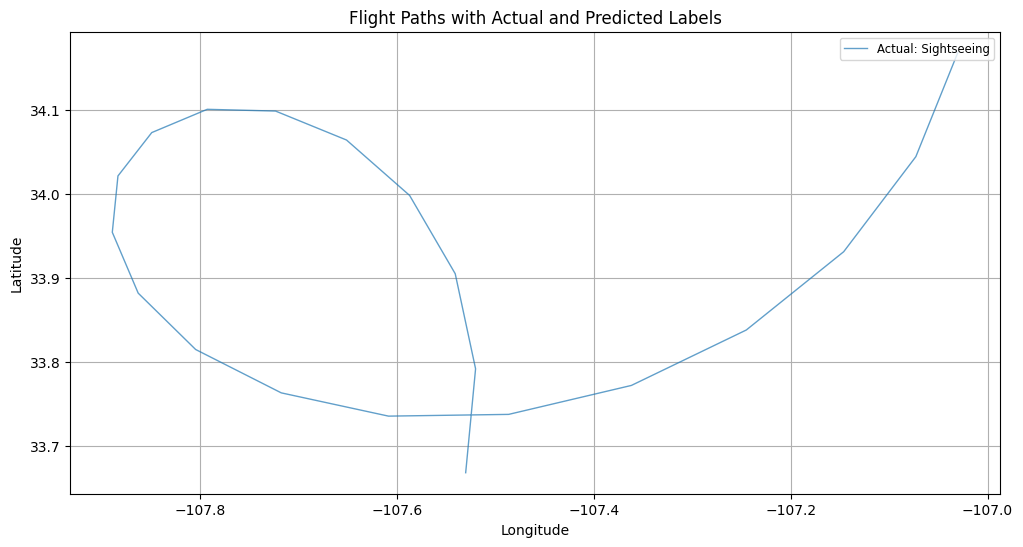

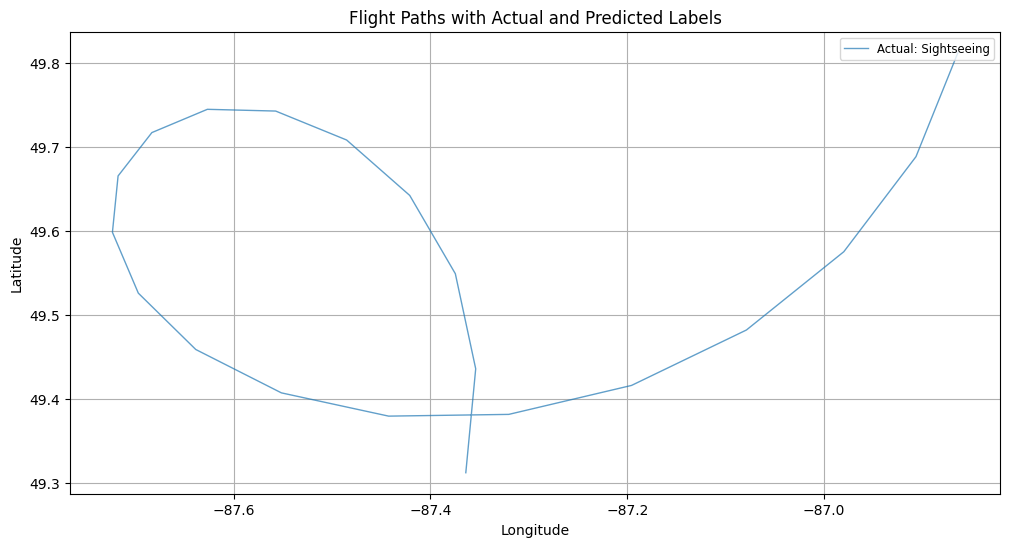

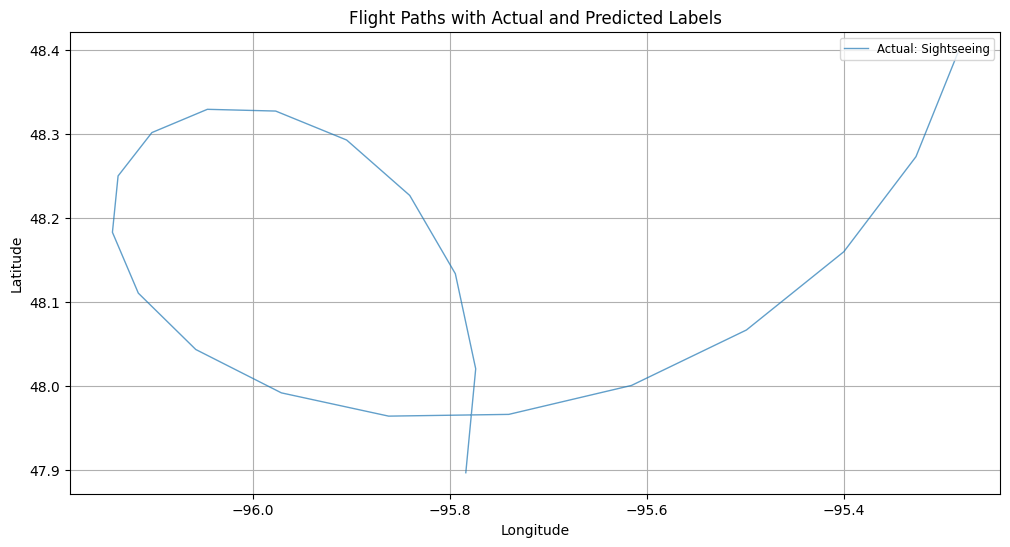

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from src.prototypes import classify_flight_path

# Load Flight Data
data = pd.read_csv('data/mocked_with_unused_labels.csv')

#  Get the first 10 unique flight IDs
first_10_flight_ids = data["flight_id"].unique()[3:4]

# Filter data for these flight IDs
filtered_data = data[data["flight_id"].isin(first_10_flight_ids)]


# Plot Flight Paths with Labels

for flight_id, flight_data in data.groupby("flight_id"):
    plt.figure(figsize=(12, 6))
    plt.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1, label=f"Actual: {flight_data['label'].iloc[0]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Flight Paths with Actual and Predicted Labels")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.show()


{'Commercial Flight': np.float64(68798.36655034061), 'Training Flight': np.float64(531240.7242761344), 'Surveillance Flight': np.float64(391229.24851837085), 'Private Flight': np.float64(589229.3418373126)}
{'Commercial Flight': np.float64(26730.373070997677), 'Training Flight': np.float64(573317.2040695454), 'Surveillance Flight': np.float64(433305.63592175406), 'Private Flight': np.float64(631304.5766867918)}
{'Commercial Flight': np.float64(93138.5344705376), 'Training Flight': np.float64(506949.49012740643), 'Surveillance Flight': np.float64(366939.4420160874), 'Private Flight': np.float64(564930.4461356493)}
{'Commercial Flight': np.float64(529238.4949372464), 'Training Flight': np.float64(70807.53743708512), 'Surveillance Flight': np.float64(69220.46935769943), 'Private Flight': np.float64(128816.90582107153)}
{'Commercial Flight': np.float64(540802.737217751), 'Training Flight': np.float64(59242.433127164004), 'Surveillance Flight': np.float64(80781.61888748694), 'Private Flight

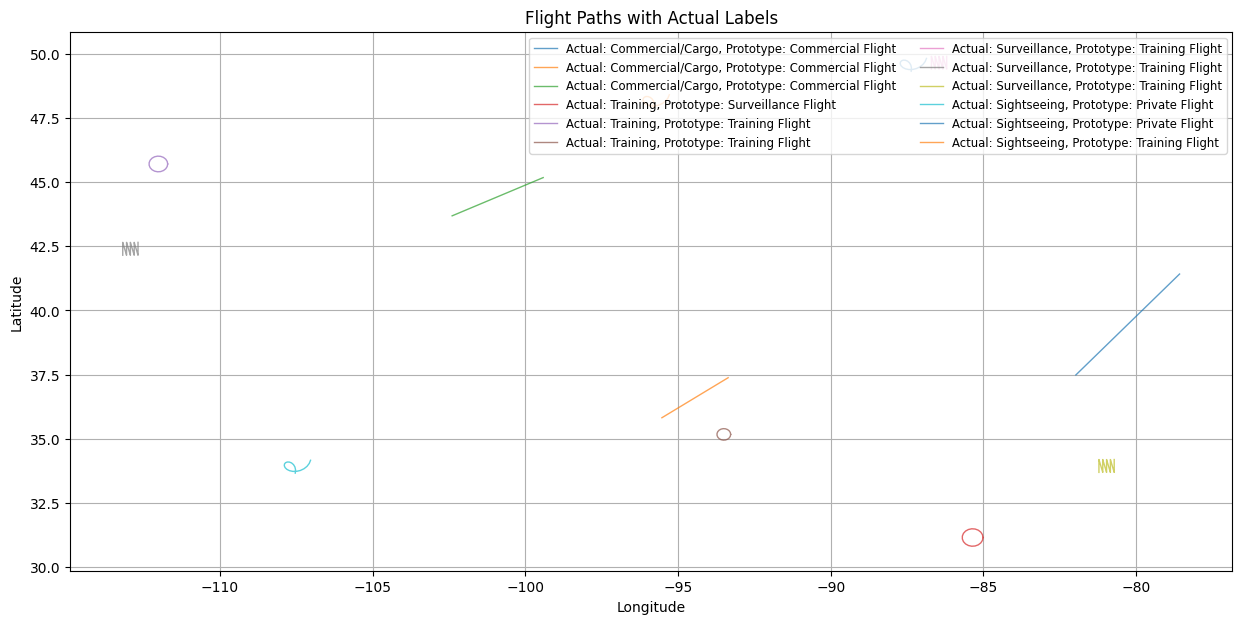

Epoch 1/20


c:\Users\mitch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.2272 - loss: 0.0557 - val_accuracy: 0.4444 - val_loss: 1.3324
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4503 - loss: 0.0521 - val_accuracy: 0.8148 - val_loss: 1.2284
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7505 - loss: 0.0448 - val_accuracy: 0.7778 - val_loss: 1.1307
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7103 - loss: 0.0409 - val_accuracy: 0.7778 - val_loss: 1.0484
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7280 - loss: 0.0416 - val_accuracy: 0.8889 - val_loss: 0.9757
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7571 - loss: 0.0360 - val_accuracy: 0.8889 - val_loss: 0.8937
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8133 - loss: 0.0333 - val_accuracy: 0.8889 - val_loss: 0.8067
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8102 - loss: 0.0299 - val_accuracy: 0.8889 - val_loss: 0.7392
Epoch 9/20

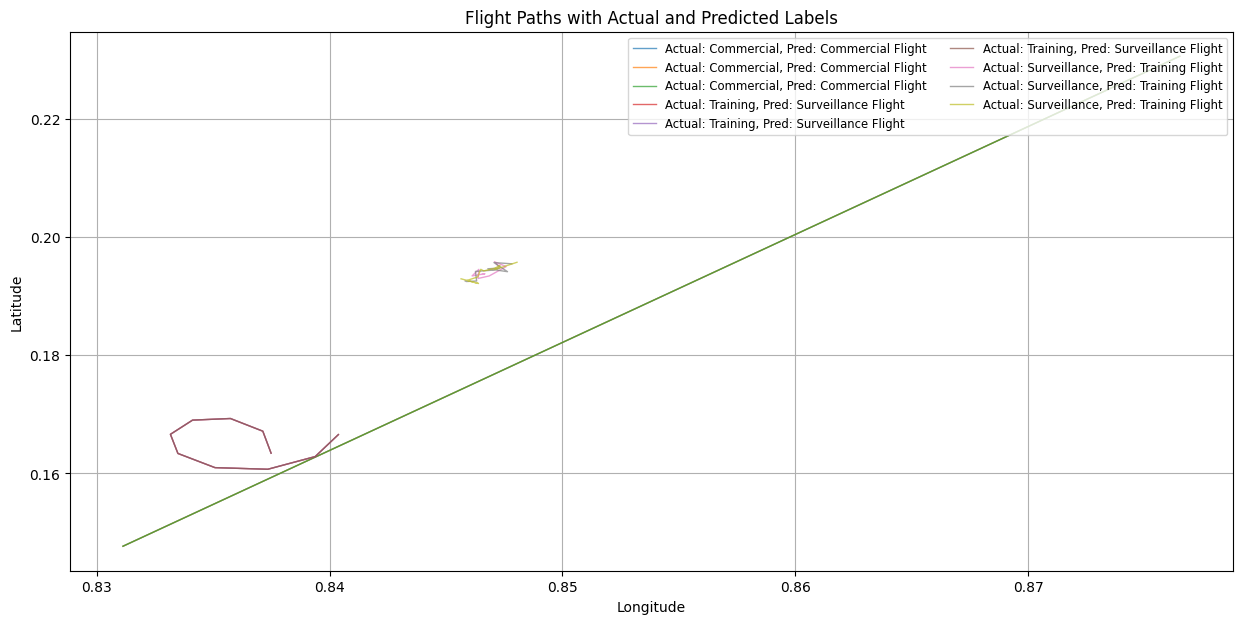

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from src.prototypes import classify_flight_path

def plot_flight_paths(data):
    plt.figure(figsize=(15, 7))
    for flight_id, flight_data in data.groupby("flight_id"):
        plt.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1, label=f"Actual: {flight_data['label'].iloc[0]}, Prototype: {flight_data['distance_label'].iloc[0]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Flight Paths with Actual Labels")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.show()

# Load Flight Data
data = pd.read_csv('data/mocked_with_unused_labels.csv')
# data = data.drop(columns=['label'])
# Label the flight paths using the 4D distance method
def label_flight_paths(data):
    labels = [(flight_id, classify_flight_path(flight_data[['lat', 'long', 'altitude', 'speed']].values.tolist()))
              for flight_id, flight_data in data.groupby('flight_id')]
    return pd.DataFrame(labels, columns=['flight_id', 'distance_label'])

data = data.merge(label_flight_paths(data), on='flight_id', how='left')
plot_flight_paths(data)
# Normalize Data
scaler = MinMaxScaler()
data[['lat', 'long', 'altitude', 'speed']] = scaler.fit_transform(data[['lat', 'long', 'altitude', 'speed']])

# Generate Sequences
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['distance_label'])



timesteps = 10
X, y = [], []
for flight_id, flight_data in data.groupby('flight_id'):
    flight_scaled = flight_data[['lat', 'long', 'altitude', 'speed']].values
    flight_labels = flight_data['encoded_label'].values
    for i in range(len(flight_scaled) - timesteps):
        X.append(flight_scaled[i:i+timesteps])
        y.append(flight_labels[i+timesteps])

X, y = np.array(X), np.array(y, dtype=np.int32)

# Train CNN Model with class weighting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = {i: 1 / (np.sum(y_train == i) + 1e-6) for i in np.unique(y_train)}

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(timesteps, 4)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, class_weight=class_weights)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on New Data
new_flight_data = pd.read_csv('data/categorized_test_data_mocked.csv')
new_flight_data[['lat', 'long', 'altitude', 'speed']] = scaler.transform(new_flight_data[['lat', 'long', 'altitude', 'speed']])

# Ensure minimum sequence length is valid
valid_flights = [flight_id for flight_id, flight_data in new_flight_data.groupby('flight_id') if len(flight_data) >= timesteps]

# Generate sequences only from valid flights
new_X = [flight_data[['lat', 'long', 'altitude', 'speed']].values[:timesteps]  # Take first 'timesteps' rows
         for flight_id, flight_data in new_flight_data.groupby('flight_id') if flight_id in valid_flights]

if new_X:  # Ensure we have valid sequences before predicting
    new_X = np.array(new_X)
    predictions = model.predict(new_X)
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    # Assign Predictions
    new_flight_data['predicted_category'] = None
    new_flight_data.loc[new_flight_data['flight_id'].isin(valid_flights), 'predicted_category'] = np.repeat(predicted_labels, timesteps)

    # Validate Predictions
    accuracy = (new_flight_data.dropna(subset=['predicted_category'])['predicted_category'] ==
                new_flight_data.dropna(subset=['predicted_category'])['label']).mean()
    print(f"Validation Accuracy: {accuracy:.2%}")
else:
    print("No valid sequences found for prediction.")

# Confusion Matrix with Actual and Predicted Flight Types
valid_labels = list(set(new_flight_data['label'].dropna()) & set(new_flight_data['predicted_category'].dropna()))
if valid_labels:
    cm = confusion_matrix(new_flight_data['label'], new_flight_data['predicted_category'], labels=valid_labels)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=valid_labels, yticklabels=valid_labels, cmap='Blues')
    plt.xlabel("Predicted Flight Type")
    plt.ylabel("Actual Flight Type")
    plt.title("Confusion Matrix of Flight Type Classification")
    plt.show()
else:
    print("No valid labels found for confusion matrix. Check your predictions.")

# Plot Flight Paths with Labels
plt.figure(figsize=(15, 7))
for flight_id, flight_data in new_flight_data.groupby("flight_id"):
    plt.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1, label=f"Actual: {flight_data['label'].iloc[0]}, Pred: {flight_data['predicted_category'].iloc[0]}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight Paths with Actual and Predicted Labels")
plt.grid(True)
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.show()
